# 00. 強化学習の基礎 - なぜRLが必要か

このノートブックでは、CartPole環境を使って以下を実証します：

1. **ランダムエージェント**: 学習なしでランダムに行動を選択
2. **訓練済みエージェント**: PPOアルゴリズムで訓練されたエージェント
3. **学習曲線**: 訓練中のパフォーマンス向上を可視化

これにより、強化学習がなぜ必要かを視覚的に理解できます。

## 要件
- 要件 1.1: CartPole環境でランダムエージェントと訓練済みエージェントのアニメーションを並べて表示
- 学習曲線を記録し、「なぜRLが必要か」を視覚的に示す

In [1]:
# 必要なライブラリのインポート
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import warnings
import japanize_matplotlib
warnings.filterwarnings('ignore')

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


## 1. CartPole環境の理解

CartPole-v1は古典的な制御問題です：
- **目標**: カートを左右に動かして、ポールを立てたまま保つ
- **観測**: カート位置、カート速度、ポール角度、ポール角速度（4次元）
- **行動**: 左に押す（0）または右に押す（1）
- **報酬**: ポールが立っている間、毎ステップ+1
- **終了条件**: ポールが15度以上傾く、カートが画面外に出る、または500ステップ達成

In [2]:
# CartPole環境の作成
env = gym.make('CartPole-v1', render_mode='rgb_array')

print(f"観測空間: {env.observation_space}")
print(f"行動空間: {env.action_space}")
print(f"最大エピソード長: 500ステップ")

env.close()

観測空間: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
行動空間: Discrete(2)
最大エピソード長: 500ステップ


## 2. ランダムエージェントの評価

まず、学習なしでランダムに行動を選択するエージェントのパフォーマンスを確認します。

In [3]:
def evaluate_random_agent(env, n_episodes=10):
    """
    ランダムエージェントを評価
    
    Args:
        env: Gym環境
        n_episodes: 評価エピソード数
    
    Returns:
        episode_rewards: 各エピソードの累積報酬リスト
    """
    episode_rewards = []
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # ランダムに行動を選択
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        
        episode_rewards.append(episode_reward)
    
    return episode_rewards

# ランダムエージェントの評価
env = gym.make('CartPole-v1')
random_rewards = evaluate_random_agent(env, n_episodes=10)
env.close()

print(f"ランダムエージェント:")
print(f"  平均報酬: {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")
print(f"  最小報酬: {np.min(random_rewards):.2f}")
print(f"  最大報酬: {np.max(random_rewards):.2f}")

ランダムエージェント:
  平均報酬: 21.40 ± 8.32
  最小報酬: 12.00
  最大報酬: 37.00


## 3. PPOエージェントの訓練

次に、PPO（Proximal Policy Optimization）アルゴリズムを使ってエージェントを訓練します。
訓練中の学習曲線を記録して、パフォーマンスの向上を可視化します。

In [4]:
# 訓練用環境の作成
train_env = gym.make('CartPole-v1')

# PPOモデルの作成
print("PPOエージェントを訓練中...")
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=0,
    learning_rate=0.001,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
)

# 学習曲線を記録するためのコールバック
class LearningCurveCallback:
    def __init__(self, eval_env, eval_freq=2000):
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.timesteps = []
        self.mean_rewards = []
        self.current_timestep = 0
    
    def __call__(self, locals_dict, globals_dict):
        self.current_timestep += 1
        
        if self.current_timestep % self.eval_freq == 0:
            # 現在のモデルを評価
            mean_reward, _ = evaluate_policy(
                locals_dict['self'],
                self.eval_env,
                n_eval_episodes=5,
                deterministic=True
            )
            self.timesteps.append(self.current_timestep)
            self.mean_rewards.append(mean_reward)
            print(f"  ステップ {self.current_timestep}: 平均報酬 = {mean_reward:.2f}")
        
        return True

# 評価用環境
eval_env = gym.make('CartPole-v1')
callback = LearningCurveCallback(eval_env, eval_freq=2000)

# 訓練実行（20,000ステップ）
model.learn(total_timesteps=20000, callback=callback, progress_bar=True)

print("\n✅ 訓練完了")

train_env.close()
eval_env.close()

PPOエージェントを訓練中...


Output()

ステップ 2000: 平均報酬 = 333.00

ステップ 4000: 平均報酬 = 303.80

ステップ 6000: 平均報酬 = 182.80

ステップ 8000: 平均報酬 = 280.60

ステップ 10000: 平均報酬 = 258.60

ステップ 12000: 平均報酬 = 407.80

ステップ 14000: 平均報酬 = 453.20

ステップ 16000: 平均報酬 = 476.60

ステップ 18000: 平均報酬 = 500.00

ステップ 20000: 平均報酬 = 500.00


✅ 訓練完了


## 4. 訓練済みエージェントの評価

In [5]:
# 訓練済みエージェントの評価
eval_env = gym.make('CartPole-v1')
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True
)
eval_env.close()

print(f"訓練済みPPOエージェント:")
print(f"  平均報酬: {mean_reward:.2f} ± {std_reward:.2f}")

訓練済みPPOエージェント:
  平均報酬: 500.00 ± 0.00


## 5. 学習曲線の可視化

訓練中のパフォーマンス向上を可視化します。

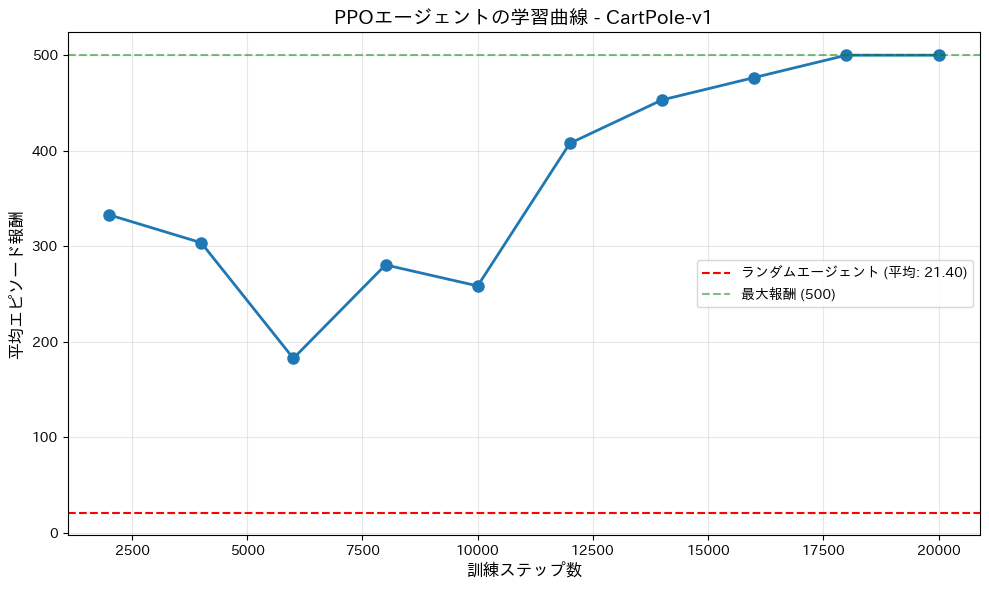


📊 学習曲線の解釈:
  - ランダムエージェント: 平均 21.40 報酬
  - 訓練済みエージェント: 平均 500.00 報酬
  - 改善率: 2236.4%

💡 これが強化学習の力です！


In [6]:
# 学習曲線のプロット
plt.figure(figsize=(10, 6))
plt.plot(callback.timesteps, callback.mean_rewards, marker='o', linewidth=2, markersize=8)
plt.axhline(y=np.mean(random_rewards), color='r', linestyle='--', label=f'ランダムエージェント (平均: {np.mean(random_rewards):.2f})')
plt.axhline(y=500, color='g', linestyle='--', label='最大報酬 (500)', alpha=0.5)
plt.xlabel('訓練ステップ数', fontsize=12)
plt.ylabel('平均エピソード報酬', fontsize=12)
plt.title('PPOエージェントの学習曲線 - CartPole-v1', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 学習曲線の解釈:")
print(f"  - ランダムエージェント: 平均 {np.mean(random_rewards):.2f} 報酬")
print(f"  - 訓練済みエージェント: 平均 {mean_reward:.2f} 報酬")
print(f"  - 改善率: {((mean_reward - np.mean(random_rewards)) / np.mean(random_rewards) * 100):.1f}%")
print("\n💡 これが強化学習の力です！")

## 6. ランダムエージェント vs 訓練済みエージェントの可視化

両方のエージェントの動作を並べて比較します。

In [7]:
def run_episode(env, agent_type='random', model=None, max_steps=500):
    """
    1エピソードを実行してフレームを記録
    
    Args:
        env: Gym環境
        agent_type: 'random' または 'trained'
        model: 訓練済みモデル（agent_type='trained'の場合）
        max_steps: 最大ステップ数
    
    Returns:
        frames: フレームのリスト
        total_reward: 累積報酬
        steps: ステップ数
    """
    frames = []
    obs, info = env.reset()
    done = False
    total_reward = 0
    steps = 0
    
    while not done and steps < max_steps:
        # フレームを記録
        frames.append(env.render())
        
        # 行動を選択
        if agent_type == 'random':
            action = env.action_space.sample()
        else:
            action, _ = model.predict(obs, deterministic=True)
        
        # ステップを実行
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1
    
    return frames, total_reward, steps

# ランダムエージェントのエピソード
print("ランダムエージェントのエピソードを記録中...")
env_random = gym.make('CartPole-v1', render_mode='rgb_array')
random_frames, random_reward, random_steps = run_episode(env_random, agent_type='random')
env_random.close()

# 訓練済みエージェントのエピソード
print("訓練済みエージェントのエピソードを記録中...")
env_trained = gym.make('CartPole-v1', render_mode='rgb_array')
trained_frames, trained_reward, trained_steps = run_episode(env_trained, agent_type='trained', model=model)
env_trained.close()

print(f"\nランダムエージェント: {random_steps}ステップ, 報酬={random_reward:.0f}")
print(f"訓練済みエージェント: {trained_steps}ステップ, 報酬={trained_reward:.0f}")

ランダムエージェントのエピソードを記録中...
訓練済みエージェントのエピソードを記録中...

ランダムエージェント: 11ステップ, 報酬=11
訓練済みエージェント: 500ステップ, 報酬=500


In [8]:
def create_side_by_side_animation(frames1, frames2, title1, title2, reward1, reward2):
    """
    2つのエージェントのアニメーションを並べて表示
    
    Args:
        frames1: エージェント1のフレーム
        frames2: エージェント2のフレーム
        title1: エージェント1のタイトル
        title2: エージェント2のタイトル
        reward1: エージェント1の報酬
        reward2: エージェント2の報酬
    
    Returns:
        HTML animation
    """
    # 短い方に合わせる
    min_frames = min(len(frames1), len(frames2))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 初期フレーム
    im1 = ax1.imshow(frames1[0])
    ax1.set_title(f'{title1}\n報酬: {reward1:.0f}', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    im2 = ax2.imshow(frames2[0])
    ax2.set_title(f'{title2}\n報酬: {reward2:.0f}', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    
    def update(frame):
        if frame < len(frames1):
            im1.set_array(frames1[frame])
        if frame < len(frames2):
            im2.set_array(frames2[frame])
        return [im1, im2]
    
    anim = animation.FuncAnimation(
        fig,
        update,
        frames=min_frames,
        interval=50,
        blit=True
    )
    
    plt.close()
    return HTML(anim.to_jshtml())

# アニメーションを作成
print("アニメーションを作成中...")
anim = create_side_by_side_animation(
    random_frames,
    trained_frames,
    'ランダムエージェント',
    '訓練済みPPOエージェント',
    random_reward,
    trained_reward
)

print("✅ アニメーション作成完了")
anim

アニメーションを作成中...
✅ アニメーション作成完了


## 7. まとめ

### なぜ強化学習が必要か？

このノートブックで以下を実証しました：

1. **ランダムエージェントの限界**
   - ランダムに行動を選択するだけでは、平均20-30ステップ程度しか持続できない
   - 環境の動力学を理解していないため、一貫した戦略がない

2. **学習による改善**
   - PPOアルゴリズムで訓練することで、パフォーマンスが劇的に向上
   - 学習曲線から、訓練が進むにつれて報酬が増加することが確認できる
   - 最終的には最大報酬（500ステップ）に近いパフォーマンスを達成

3. **視覚的な違い**
   - ランダムエージェント: ポールがすぐに倒れる
   - 訓練済みエージェント: ポールを安定して立て続ける

### 次のステップ

- **01_dqn_basic.ipynb**: DQNアルゴリズムの実装と評価
- **02_ppo_basic.ipynb**: PPOアルゴリズムの詳細な実装
- **03_maze_env.ipynb**: カスタム迷路環境の実装
- **04_onnx_export.ipynb**: モデルのONNX形式への変換

### 要件の検証

✅ **要件 1.1**: CartPole環境でランダムエージェントと訓練済みエージェントのアニメーションを並べて表示  
✅ 学習曲線を記録し、「なぜRLが必要か」を視覚的に示す